In [1]:
#change Kernel to "...tensorflow_27
#we are importing packages

import scipy.io
import scipy.misc
import tensorflow as tf
import numpy as np
import time
from IPython.display import Image

from __future__ import print_function
from keras.preprocessing.image import load_img, img_to_array
from scipy.misc import imsave #to be able to save as an image
from scipy.optimize import fmin_l_bfgs_b #to optimize our cost function

from keras.applications import vgg19 #to load vgg19 network
from keras import backend as K

Using TensorFlow backend.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import keras
print(tf.__version__)
print(keras.__version__)

from keras.utils.vis_utils import plot_model #to be able to visualize the network
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

1.13.0-rc1
2.2.4


In [0]:
content_file_directory = 'drive/My Drive/ArtML/Style Transfer/in_frames/'

In [0]:
iterations =5 #we will run 5 iterations during the optiomization. each iteration you get better value. this one is for about 15 min. running. 

# these are the weights of the different loss components
total_variation_weight = 8.5e-05
style_weight = 1.0 #the best number authors got from their trials 
content_weight = 0.025 #the best number authors got from their trials 

In [0]:
# let's load images

base_image_path = content_file_directory
style_reference_image_path = 'n.jpg'#+style_file_name

styled_image_path = 'drive/My Drive/ArtML/Style Transfer/out_mean/'

# get dimensions (width, height) of the generated picture
width, height = load_img(base_image_path+'frame0001.jpg').size

img_nrows = 400 #rescale the image to 400 pixel rows 
img_ncols = int(width * img_nrows / height)

In [0]:
# pre-process the image: rescaling, running it through VGG19

def preprocess_image(image_path):

    img = load_img(image_path, target_size=(img_nrows, img_ncols))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return img


# utility function to convert a tensor into a valid image

def deprocess_image(x):

    if K.image_data_format() == 'channels_first':
        x = x.reshape((3, img_nrows, img_ncols))
        x = x.transpose((1, 2, 0))

    else:

        x = x.reshape((img_nrows, img_ncols, 3))

    # Remove zero-center by mean pixel

    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68

    # 'BGR'->'RGB'

    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

#calculating the mean pixel values of the VGG network. We will use these values for normalization.
#mean = data['meta'][0][0][2][0][0][2]
#mean_pixel = np.mean(mean, axis=(0, 1))
#print(mean_pixel)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """Entry point for launching an IPython kernel.


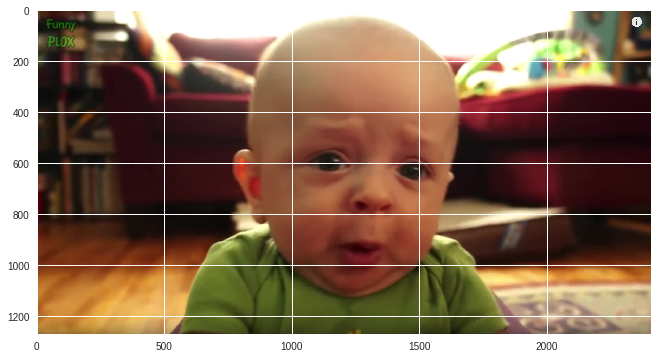

In [22]:
image_content = scipy.misc.imread(base_image_path+'frame0001.jpg')
plt.figure(figsize=(11,11))
plt.imshow(image_content)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """Entry point for launching an IPython kernel.


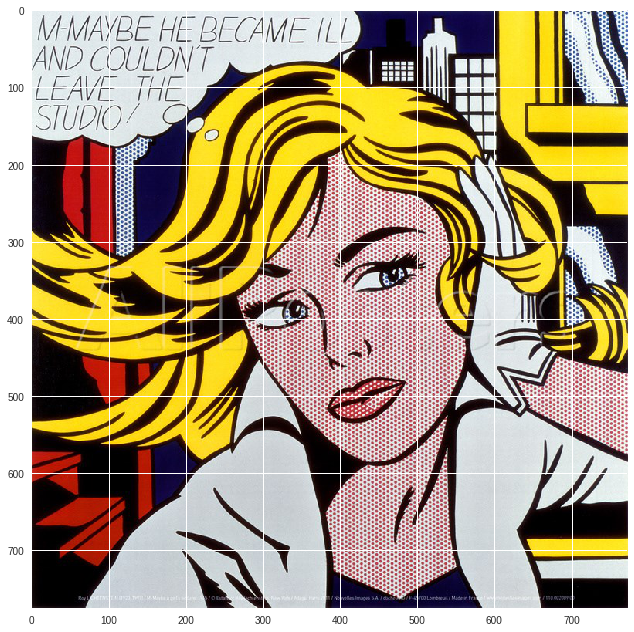

In [23]:
image_style = scipy.misc.imread(style_reference_image_path)
#image_content= scipy.misc.imresize(image_content,(224,224))
plt.figure(figsize=(11,11))
plt.imshow(image_style)



In [0]:
# compute the neural style loss
# first we need to define 4 utility functions
# the gram matrix of an image tensor (feature-wise outer product)

def gram_matrix(x):

    assert K.ndim(x) == 3
    if K.image_data_format() == 'channels_first':
        features = K.batch_flatten(x)
    else:
        features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))

    gram = K.dot(features, K.transpose(features))
    return gram

In [0]:
# the "style loss" is designed to maintain
# the style of the reference image in the generated image.
# It is based on the gram matrices (which capture style) of
# feature maps from the style reference image
# and from the generated image

def style_loss(style, combination):

    assert K.ndim(style) == 3
    assert K.ndim(combination) == 3

    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_nrows * img_ncols
    return K.sum(K.square(S - C)) / (4. * (channels ** 2) * (size ** 2))


In [0]:
# an auxiliary loss function
# designed to maintain the "content" of the
# base image in the generated image

def content_loss(base, combination):
    return K.sum(K.square(combination - base))


In [0]:
# the 3rd loss function, total variation loss,
# designed to keep the generated image locally coherent (no big changes)

def total_variation_loss(x):
    assert K.ndim(x) == 4
    if K.image_data_format() == 'channels_first':

        a = K.square(x[:, :, :img_nrows - 1, :img_ncols - 1] - x[:, :, 1:, :img_ncols - 1])
        b = K.square(x[:, :, :img_nrows - 1, :img_ncols - 1] - x[:, :, :img_nrows - 1, 1:])
    else:
        a = K.square(x[:, :img_nrows - 1, :img_ncols - 1, :] - x[:, 1:, :img_ncols - 1, :])
        b = K.square(x[:, :img_nrows - 1, :img_ncols - 1, :] - x[:, :img_nrows - 1, 1:, :])
    return K.sum(K.pow(a + b, 1.25))

In [0]:
# the 4th loss function, stabilization loss,
# designed to maintain the stability of current image with the previously generated image

def stabilization_loss(x,y):
    assert K.ndim(x) == 4 and K.ndim(y) == 4
    return K.mean(K.square(x - y))

In [0]:
def eval_loss_and_grads(x):

    if K.image_data_format() == 'channels_first':
        x = x.reshape((1, 3, img_nrows, img_ncols))
    else:
        x = x.reshape((1, img_nrows, img_ncols, 3))

    outs = f_outputs([x])
    loss_value = outs[0]
    if len(outs[1:]) == 1:
        grad_values = outs[1].flatten().astype('float64')
    else:
        grad_values = np.array(outs[1:]).flatten().astype('float64')
    return loss_value, grad_values



In [0]:
# this Evaluator class makes it possible
# to compute loss and gradients in one pass
# while retrieving them via two separate functions,
# "loss" and "grads". This is done because scipy.optimize
# requires separate functions for loss and gradients,
# but computing them separately would be inefficient.

class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

In [0]:
## run the following for all the frames (150 in our case)

for i in range(1,150):
    
    print("For image :frame"+str(i).zfill(4) +'.jpg')
    
    # our base image
    base_image = K.variable(preprocess_image(base_image_path+'frame'+str(i).zfill(4)+'.jpg'))
    
    # our style reference image
    style_reference_image = K.variable(preprocess_image(style_reference_image_path))
    
    # don't search the previous styled images for the beginning frame 
    if i!=1:
        prev_styled_image = K.variable(preprocess_image(styled_image_path+'frame'+str(i-1).zfill(4)+'.jpg'))

    # this will contain our generated image
    if K.image_data_format() == 'channels_first':
        combination_image = K.placeholder((1, 3, img_nrows, img_ncols))
    else:
        combination_image = K.placeholder((1, img_nrows, img_ncols, 3))


    # combine the 3 images (style, content, result image that starts from the white noise) into a single Keras tensor

    input_tensor = K.concatenate([base_image,
                                  style_reference_image,
                                  combination_image], axis=0)
    
    # build the VGG19 network with our 3 images as input
    # the model will be loaded with pre-trained ImageNet weights

    model = vgg19.VGG19(input_tensor=input_tensor,weights='imagenet', include_top=False)
    
    # get the symbolic outputs of each "key" layer (we gave them unique names).
    outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])
    loss = K.variable(0.)
    layer_features = outputs_dict['block5_conv2'] #content features
    base_image_features = layer_features[0, :, :, :]
    combination_features = layer_features[2, :, :, :]
    
    # add the content loss to the loss component
    loss += content_weight * content_loss(base_image_features,
                                          combination_features)
    
    feature_layers = ['block1_conv1', 'block2_conv1',
                  'block3_conv1', 'block4_conv1',
                  'block5_conv1']
    
    # add the style loss to the loss component
    for layer_name in feature_layers:
        layer_features = outputs_dict[layer_name]
        style_reference_features = layer_features[1, :, :, :]
        combination_features = layer_features[2, :, :, :]
        sl = style_loss(style_reference_features, combination_features)
        loss += (style_weight / len(feature_layers)) * sl

    # add the total variation loss to the loss component
    loss += total_variation_weight * total_variation_loss(combination_image)
    
    # add the stabilization loss to the loss component
    if i!=1:
        loss += stabilization_loss(combination_image, prev_styled_image)
    
    # get the gradients of the generated image wrt the loss

    grads = K.gradients(loss, combination_image)
    outputs = [loss]

    if isinstance(grads, (list, tuple)):
        outputs += grads
    else:
        outputs.append(grads)

    f_outputs = K.function([combination_image], outputs)
    
    evaluator = Evaluator()
    
    # run scipy-based optimization (L-BFGS) over the pixels of the generated image
    # so as to minimize the neural style loss
    x = preprocess_image(base_image_path+'frame'+str(i).zfill(4)+'.jpg')
    
    result_dir ='drive/My Drive/ArtML/Style Transfer/out_mean/'
    
    # minimise the loss function
    img = None
    for j in range(5):

        x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),
                                         fprime=evaluator.grads, maxfun=20)
        if j%5==4:
            # save the generated image of the last iteration
            img = deprocess_image(x.copy())
    fname = result_prefix+'frame'+str(i).zfill(4)+'.jpg'
    imsave(fname, img)

For image :frame0001.jpg


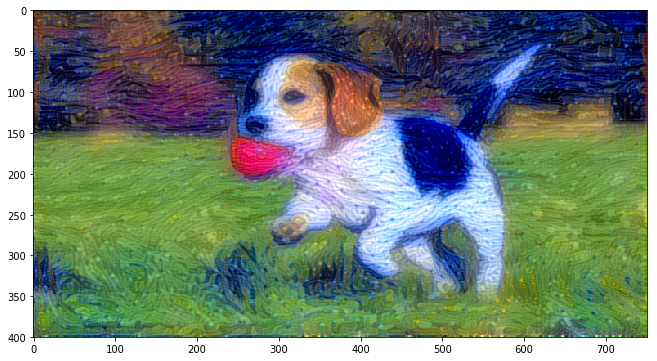

In [0]:
#image_content= scipy.misc.imresize(image_content,(224,224))
plt.figure(figsize=(11,11))
plt.imshow(img)